**Problem Statement:** 

You are working with the government to transform your city into a smart city. The vision is to convert it into a digital and intelligent city to improve the efficiency of services for the citizens. One of the problems faced by the government is traffic. You are a data scientist working to manage the traffic of the city better and to provide input on infrastructure planning for the future.

The government wants to implement a robust traffic system for the city by being prepared for traffic peaks. They want to understand the traffic patterns of the four junctions of the city.

Traffic patterns on holidays, as well as on various other occasions during the year, differ from normal working days. This is important to take into account for your forecasting.

**TASK** Predict traffic patterns in each of these four junctions for the next 4 months.



In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',100)

In [29]:
from xgboost import XGBRegressor,plot_importance

In [30]:
train=pd.read_csv('train.csv',parse_dates=['DateTime'])
test=pd.read_csv('test.csv',parse_dates=['DateTime'])
sub=pd.read_csv('sub.csv')

In [31]:
train.head().append(train.tail())

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224
48119,2017-06-30 23:00:00,4,12,20170630234


In [32]:
test.head().append(test.tail())

,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041
11803,2017-10-31 19:00:00,4,20171031194
11804,2017-10-31 20:00:00,4,20171031204
11805,2017-10-31 21:00:00,4,20171031214
11806,2017-10-31 22:00:00,4,20171031224
11807,2017-10-31 23:00:00,4,20171031234


Here, Vehicles which is the vehicle count at a particular hour is the target Feature which we need to predict for the timeperiod (2017-07-01 - 2017-10-01) using Train data from(2015-11-01 - 2017-06-30)


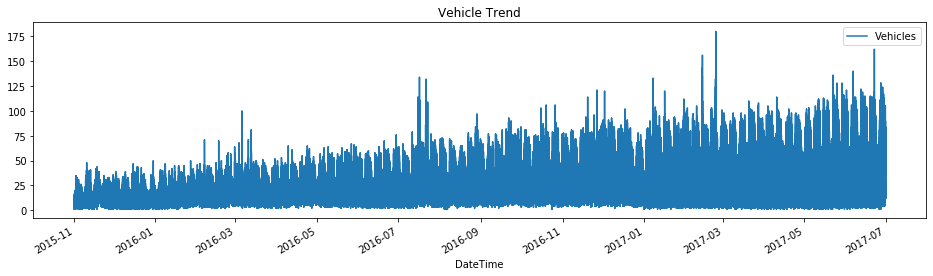

In [33]:
train.loc[:,['DateTime','Vehicles']].plot(x='DateTime',y='Vehicles',title='Vehicle Trend',figsize=(16,4))

By Analysing our data we have found out that 2015 data has very low vehicle trend compared to the timeperiod 2017 which we are going to predict and also 2015 has only data for the month- 11&12 which has different trend compared to the month (7,8,9&10) for which we need to predict.So we decided to ignore 2015 data .


In [34]:
train=train[train['DateTime']>='2016-01-01']

In [35]:
def create_date_features(df):
    df['Year']=pd.to_datetime(df['DateTime']).dt.year
    df['Month']=pd.to_datetime(df['DateTime']).dt.month
    df['Day']=pd.to_datetime(df['DateTime']).dt.day
    df['Dayofweek']=pd.to_datetime(df['DateTime']).dt.dayofweek
    df['Week']=pd.to_datetime(df['DateTime']).dt.week
    df['Quarter']=pd.to_datetime(df['DateTime']).dt.quarter
    df['Dayofyear']=pd.to_datetime(df['DateTime']).dt.dayofyear
    df['Semester']=np.where(df['Quarter'].isin([1,2]),1,2)
    df['is_weekend']=np.where(df['Dayofweek'].isin([5,6]),1,0)
    df['Hour']=pd.to_datetime(df['DateTime']).dt.hour
    
    return df

In [36]:
train=create_date_features(train)
test=create_date_features(test)

C:\Users\91999\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43728 entries, 1464 to 48119
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DateTime    43728 non-null  datetime64[ns]
 1   Junction    43728 non-null  int64         
 2   Vehicles    43728 non-null  int64         
 3   ID          43728 non-null  int64         
 4   Year        43728 non-null  int64         
 5   Month       43728 non-null  int64         
 6   Day         43728 non-null  int64         
 7   Dayofweek   43728 non-null  int64         
 8   Week        43728 non-null  int64         
 9   Quarter     43728 non-null  int64         
 10  Dayofyear   43728 non-null  int64         
 11  Semester    43728 non-null  int32         
 12  is_weekend  43728 non-null  int32         
 13  Hour        43728 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(11)
memory usage: 4.7 MB


In [38]:
for col in ['Junction']:
    train = pd.get_dummies(train, columns=[col])
    test = pd.get_dummies(test, columns=[col])


In [39]:
# reset index
train.reset_index(drop=True, inplace=True)


In [40]:
test.head()

,DateTime,ID,Year,Month,Day,Dayofweek,Week,Quarter,Dayofyear,Semester,is_weekend,Hour,Junction_1,Junction_2,Junction_3,Junction_4
0,2017-07-01 00:00:00,20170701001,2017,7,1,5,26,3,182,2,1,0,1,0,0,0
1,2017-07-01 01:00:00,20170701011,2017,7,1,5,26,3,182,2,1,1,1,0,0,0
2,2017-07-01 02:00:00,20170701021,2017,7,1,5,26,3,182,2,1,2,1,0,0,0
3,2017-07-01 03:00:00,20170701031,2017,7,1,5,26,3,182,2,1,3,1,0,0,0
4,2017-07-01 04:00:00,20170701041,2017,7,1,5,26,3,182,2,1,4,1,0,0,0


In [41]:
train.head()

,DateTime,Vehicles,ID,Year,Month,Day,Dayofweek,Week,Quarter,Dayofyear,Semester,is_weekend,Hour,Junction_1,Junction_2,Junction_3,Junction_4
0,2016-01-01 00:00:00,13,20160101001,2016,1,1,4,53,1,1,1,0,0,1,0,0,0
1,2016-01-01 01:00:00,13,20160101011,2016,1,1,4,53,1,1,1,0,1,1,0,0,0
2,2016-01-01 02:00:00,11,20160101021,2016,1,1,4,53,1,1,1,0,2,1,0,0,0
3,2016-01-01 03:00:00,6,20160101031,2016,1,1,4,53,1,1,1,0,3,1,0,0,0
4,2016-01-01 04:00:00,8,20160101041,2016,1,1,4,53,1,1,1,0,4,1,0,0,0


In [42]:
train['DateTime'][0].toordinal()

735964

C:\Users\91999\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


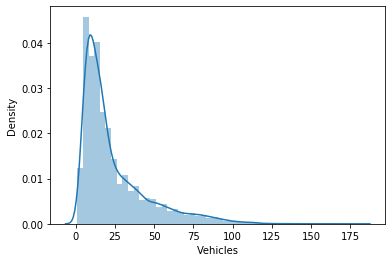

In [43]:
sns.distplot(train['Vehicles'])

Log transforming Vehicle to have normal distribution

C:\Users\91999\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


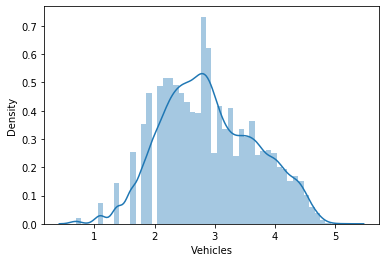

In [44]:
sns.distplot(np.log1p(train['Vehicles']))

In [45]:
train['Vehicles']=np.log1p(train['Vehicles'])

Timeseries problems requires time based validation instead of generaly used kfold validation in regression problem. Kfold splits the data randomly and checking the model accuracy by predicting on timeperiod 2016 by using 2017 data makes no sense.
Here we used time based validation for the time period (2017-01-01 to 2017-04-01) of 4 months, since the test set contains 4 months data to predict.

In [46]:
train1=train[train['DateTime']<'2017-03-01'] #Train period from 2016-01-01 to 2017-02-31
val1=train[train['DateTime']>='2017-03-01'] #Month 3,4,5,6 as validtaion period


In [47]:
def datetounix(df):
    unixtime=[]
    #Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    #Replacing date with unixtime list
    df['DateTime']=unixtime
    return(df)

In [48]:
train1=datetounix(train1)
val1=datetounix(val1)

train=datetounix(train)
test=datetounix(test)


C:\Users\91999\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [49]:
x_train1=train1.drop(columns={'ID','Vehicles'},axis=1)
y_train1=train1.loc[:,['Vehicles']]

x_val1=val1.drop(columns={'ID','Vehicles'},axis=1)
y_val1=val1.loc[:,['Vehicles']]


In [50]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    booster = "gbtree",
    n_estimators=100000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
    seed=42,
    objective='reg:linear')

model.fit(
    x_train1, 
    y_train1, 
    eval_metric="rmse", 
    eval_set=[(x_train1, y_train1), (x_val1, y_val1)], 
    verbose=True, 
    early_stopping_rounds = 100)

time.time() - ts


[15:46:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.75077	validation_1-rmse:1.93087
[1]	validation_0-rmse:1.24564	validation_1-rmse:1.42354
[2]	validation_0-rmse:0.89510	validation_1-rmse:1.05687
[3]	validation_0-rmse:0.66521	validation_1-rmse:0.79771
[4]	validation_0-rmse:0.50345	validation_1-rmse:0.60896
[5]	validation_0-rmse:0.39986	validation_1-rmse:0.48916
[6]	validation_0-rmse:0.33466	validation_1-rmse:0.39929
[7]	validation_0-rmse:0.29582	validation_1-rmse:0.36346
[8]	validation_0-rmse:0.27181	validation_1-rmse:0.33120
[9]	validation_0-rmse:0.25906	validation_1-rmse:0.31978
[10]	validation_0-rmse:0.24884	validation_1-rmse:0.31014
[11]	validation_0-rmse:0.24421	validation_1-rmse:0.30608
[12]	validation_0-rmse:0.24122	validation_1-rmse:0.30787
[13]	validation_0-rmse:0.23867	validation_1-rmse:0.31258
[14]	validation_0-rmse:0.23706	vali

2.1108968257904053

In [51]:
pred=model.predict(x_val1)


In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt
np.sqrt(mean_squared_error(np.expm1(y_val1), np.expm1(pred)))

7.338551181294541

In [53]:
# Function to plot feature importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


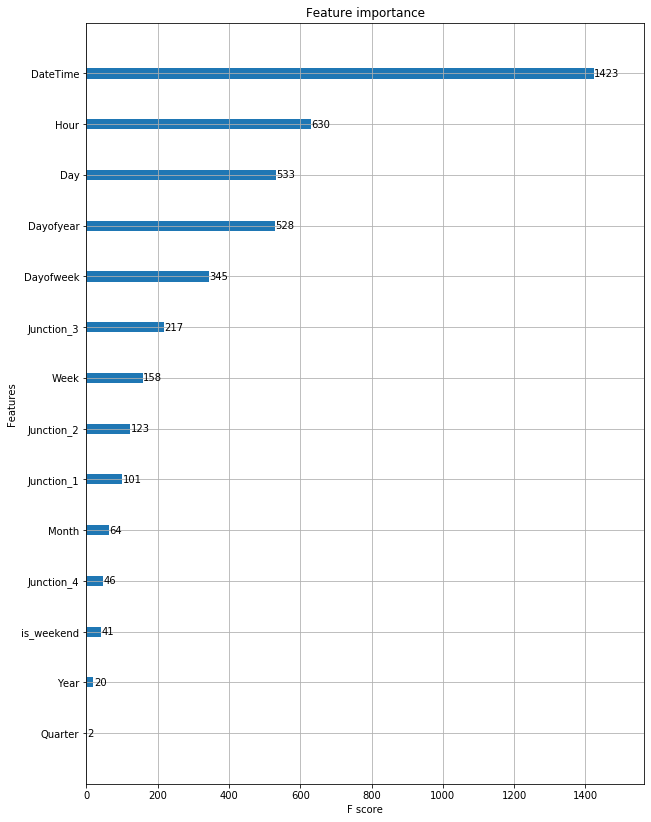

In [54]:
plot_features(model, (10,14))

In [59]:
x_val1.head()

,DateTime,Year,Month,Day,Dayofweek,Week,Quarter,Dayofyear,Semester,is_weekend,Hour,Junction_1,Junction_2,Junction_3,Junction_4
10200,1.488307e+09,2017,3,1,2,9,1,60,1,0,0,1,0,0,0
10201,1.488310e+09,2017,3,1,2,9,1,60,1,0,1,1,0,0,0
10202,1.488314e+09,2017,3,1,2,9,1,60,1,0,2,1,0,0,0
10203,1.488317e+09,2017,3,1,2,9,1,60,1,0,3,1,0,0,0
10204,1.488321e+09,2017,3,1,2,9,1,60,1,0,4,1,0,0,0


In [60]:
test.head()

,DateTime,ID,Year,Month,Day,Dayofweek,Week,Quarter,Dayofyear,Semester,is_weekend,Hour,Junction_1,Junction_2,Junction_3,Junction_4
0,1.498847e+09,20170701001,2017,7,1,5,26,3,182,2,1,0,1,0,0,0
1,1.498851e+09,20170701011,2017,7,1,5,26,3,182,2,1,1,1,0,0,0
2,1.498855e+09,20170701021,2017,7,1,5,26,3,182,2,1,2,1,0,0,0
3,1.498858e+09,20170701031,2017,7,1,5,26,3,182,2,1,3,1,0,0,0
4,1.498862e+09,20170701041,2017,7,1,5,26,3,182,2,1,4,1,0,0,0


In [61]:
test=test.drop('ID',axis=1)

In [62]:
predt=model.predict(test)